In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Currently data is in directories like

#########################################################
# With this the whole file structure had to be changed.
# TODO Use code for test train split, currently the last 10 or so files are used as test, not randomly
#   For test/train split
#       get list of positives and negatives, test/train split the list.
#       move all filenames in that list to either test, or train directory
#########################################################

In [4]:
# Try a new CNN with the input data augmented so it will classify obscured spheres
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# CNN has been trained previously, just loading in weights so commented out
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Made this into a function so that I can rerun and load weights
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

########################################################## New Cell? #########################################

batch_size = 16 # TODO find out what batch_size is

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.0,
        height_shift_range=0.0, # From 0.2 to 0 ONLY MIDDLE
        zoom_range=[1,2],       # Changed to zoom out 5 -> 4 was too good
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'TrainingImages/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'TrainingImages/train',  # this is the target directory
        target_size=(51, 51),  # all images will be resized to 51x51
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'TrainingImages/test',
        target_size=(51, 51),
        batch_size=batch_size,
        class_mode='binary')

# TODO search more about these hyperparameters
# steps_per_epoch???? 

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,       # Can Increase later but I dont think more epochs really help it
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

model.save('CNN_Model.h5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 2830 images belonging to 2 classes.
Found 95 images belonging to 2 classes.

Epoch 1/5
125/125 [==============================] - 32s 255ms/step - loss: 0.1631 - accuracy: 0.9525 - val_loss: 0.1936 - val_accuracy: 0.9457
Epoch 2/5
125/125 [==============================] - 19s 155ms/step - loss: 0.0196 - accuracy: 0.9945 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 3/5
125/125 [==============================] - 13s 105ms/step - loss: 0.0247 - accuracy: 0.9990 - val_loss: 7.0948e-05 - val_accuracy: 0.9886
Epoch 4/5
125/125 [==============================] - 15s 120ms/step - loss: 0.0420 - accuracy: 0.9960 - val_loss: 2.7742e-06 - val_accuracy: 0.9899
Epoch 5/5
125/125 [==============================] - 13s 108ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.2401 - val_accuracy: 0.9886


In [3]:
# Load model
from tensorflow import keras

model = keras.models.load_model('CNN_Model.h5')

# Classifier is trained
Now the classifier has been sufficiently trained we can use it on the pacman data

1 - First I will define the functions I created for the task

2 - Then I will use the PacMan code to play the game 

In [4]:

############### OLD BUT KEPT FOR REFERENCE #####################
# Define function sliding window
# returns array of windows that I can classify at once
def sliding_window( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size):   # Verticle
        for x in range (0, image_width-window_size, step_size):   #horizontal
            windows.append(image[y:y+window_size, x:x+window_size, :])
    print('Number of windows: {}'.format(len(windows)))

    return np.array(windows) # Return windows as np array

# This function goes through windows in an image, 
# The function takes in step_size
# Returns the x,y coordinates of the start of window containing spheres, and distance to sphere as a np array
def sliding_window_classifier( step_size, image, mapx, mapy, mapz, depth ):    # REMOVE MAPX,Y,Z
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    result = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):

            window = image[y:y+window_size, x:x+window_size, :]

            #Normaly you predict on an array of value, but here since we want the (x,y) coordinates this is easier
            window = np.expand_dims(window, axis=0) # Adds first dimension to data (1,51,51,3) -> (1,51,51,3)
            prediction = model.predict( np.array( window ) )
            prediction = prediction[0][0] #  Unpack prediction [[1.]] -> 1

            # Only want patches we are 100% sure contain spheres
            if (prediction == 1):                
                print(f'Middle pixel Depth: {depth[y+25, x+25]}')   # TODO call depth as a parameter or ensure it is correct
                print(f'Coordinates of sphere: {[mapx[y+25, x+25], mapy[y+26, x+26], mapz[y+26, x+26]]}')

                plt.figure(figsize=(2,1))
                plt.title('Image')
                plt.imshow( window[0,:,:,:] )   
        
                # Add 'crosshair' to show middle pixel
                ax=plt.gca() 
                ax.spines['left'].set_position('center')
                ax.spines['bottom'].set_position('center')
                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                plt.show()

                # Spheres are always in the centre of the window.
                # Middle depth is the depth of the pixel in the centre of the sphere and window.
                middle_depth = depth[y+25, x+25]

                # Need these to be returned so we can move to the closest sphere.
                result.append( (x, y, middle_depth) )

    # Results are np array with columns: x, y, depth
    # If length is 0 then no spheres were found
    return np.asarray(result)   

# Not for task but function to nicely visualise allmaps
def visualise_maps(image, mapx, mapy, mapz, depth):
    # Inputs can be full 160x240 or 51x51 in size
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

    ax[0].set_title('image')
    im0 = ax[0].imshow(image)
    #fig.colorbar(im, ax=ax[0])

    ax[1].set_title('mapx')
    im1 = ax[1].imshow(mapx, cmap='bwr')
    fig.colorbar(im1, ax=ax[1])

    ax[2].set_title('mapy')
    im2 = ax[2].imshow(mapy, cmap='bwr')
    fig.colorbar(im2, ax=ax[2])

    ax[3].set_title('mapz')
    im3 = ax[3].imshow(mapz, cmap='bwr')
    fig.colorbar(im3, ax=ax[3])

    ax[4].set_title('depth')
    im4 = ax[4].imshow(depth, cmap='bwr')
    fig.colorbar(im4, ax=ax[4])
    plt.show()
    print()


# This will change a lot
# First draft here to make code less messy
def sphere_position(x, y, position, spheres_collected):
    # x,y
    # Given coordinates of sphere, 
    #   find x, y, z of sphere
    #   set that as position

    # For now going with move to middle pixel

    newx = mapx[y+25, x+25] #-0.2603576553033593    # I want Y, X not X, Y 
    newy = mapy[y+25, x+25] #0.04575819465891324
    newz = mapz[y+25, x+25] #2.330109222847228

    # Spheres location specified with 2dp so no point in using more than that.
    newx = np.round(newx, decimals=2) #-0.26
    newy = np.round(newy, decimals=2) #0.04
    newz = np.round(newz, decimals=2) #2.33

    print(f'I am at position {position}')
    print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')

    # Move position and update scene
    position = np.asarray([newx, newy, newz])
    print(f'I am now at position {position}')

    #IndexError: index 0 is out of bounds for axis 0 with size 0 -> error with spheres_collected normally
    global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
    print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')

    #print([newx, newy, newz])
    print('####################################################################################################################')

    # Fixed error where spheres_collected wouldnt update as it wasnt returned
    return global_cloud, spheres_collected, position

Start time:
19:33:04
Getting maps.... may take a while


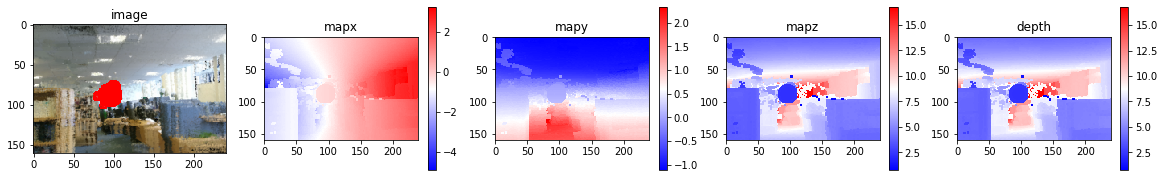


I have rotation  [0, 0, 0]
Prediction percentage: 1.0 

Middle pixel Depth: 8.927417912329389
Coordinates of sphere: [-1.076944351196289, -0.021578330894868214, 2.3790972719239245]


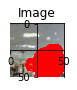

Prediction percentage: 1.0 

Middle pixel Depth: 2.362394660377316
Coordinates of sphere: [-0.18864053057926217, -0.019816509555381334, 2.3452208318322474]


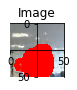

Prediction percentage: 1.0 

Middle pixel Depth: 4.701938957886521
Coordinates of sphere: [-0.258083725965501, -0.02068846886656743, 2.4060740851595215]


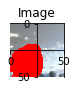

Prediction percentage: 1.0 

Middle pixel Depth: 2.3450562704232105
Coordinates of sphere: [-0.2603576553033593, 0.05510028477643353, 2.3234853872846455]


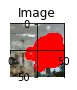

Prediction percentage: 1.0 

Middle pixel Depth: 2.358445152176713
Coordinates of sphere: [-0.26208158696191186, 0.11313504329078472, 2.3402081891374236]


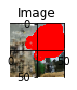

I am at position [0, 0, 0]
I have found 0 out of 11 spheres!

I am now at position [-0.26, 0.05, 2.33]
I have found 1 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


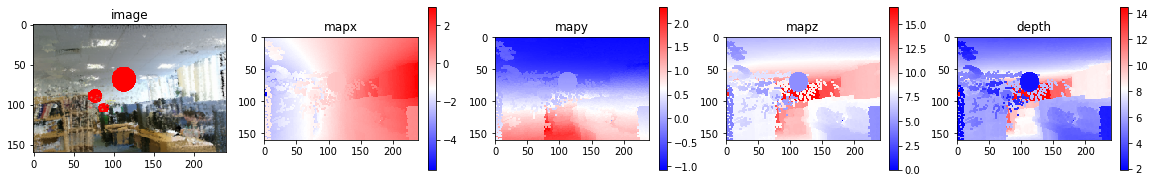


I have rotation  [0, 0, 0]
Prediction percentage: 1.0 

Middle pixel Depth: 7.911439126827869
Coordinates of sphere: [-0.6784766912460327, -0.13066769031607686, 4.737091189826103]


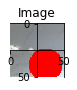

Prediction percentage: 1.0 

Middle pixel Depth: 2.359415216082156
Coordinates of sphere: [-0.36624945503924744, -0.04816729100167534, 4.680461774352237]


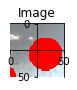

Prediction percentage: 1.0 

Middle pixel Depth: 2.348147436969395
Coordinates of sphere: [-0.30909734197236477, -0.04785214851673626, 4.6752569721412565]


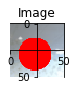

Prediction percentage: 1.0 

Middle pixel Depth: 2.363533310032611
Coordinates of sphere: [-0.36667351570726936, 0.00747351570726941, 4.6905857860553315]


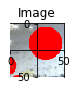

Prediction percentage: 1.0 

Middle pixel Depth: 4.744509516286793
Coordinates of sphere: [-0.9411237294834937, 0.1669245987048337, 7.01702726381289]


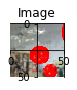

Prediction percentage: 1.0 

Middle pixel Depth: 4.7452768106626255
Coordinates of sphere: [-0.9451353826510359, 0.27754087665892246, 7.032285510295741]


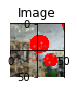

I am at position [-0.26, 0.05, 2.33]
I have found 1 out of 11 spheres!

I am now at position [-0.31, -0.06, 4.68]
I have found 2 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


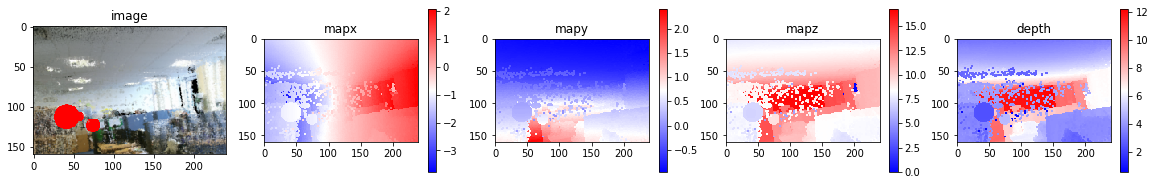


I have rotation  [0, 0, 0]
Prediction percentage: 1.0 

Middle pixel Depth: 2.4473094373156483
Coordinates of sphere: [-0.9646418053410868, 0.15468313012827925, 7.022485387284645]


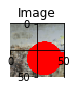

Prediction percentage: 1.0 

Middle pixel Depth: 2.439446306893001
Coordinates of sphere: [-0.9090279314135606, 0.15517131442195908, 7.034510448266663]


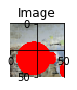

Prediction percentage: 1.0 

Middle pixel Depth: 2.431285955624163
Coordinates of sphere: [-0.958264102504298, 0.20771553486543579, 7.0079437155149185]


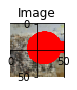

Prediction percentage: 1.0 

Middle pixel Depth: 2.4718158132107426
Coordinates of sphere: [-0.9673155491702704, 0.2916195508472614, 7.045520903852927]


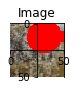

Prediction percentage: 1.0 

Middle pixel Depth: 4.802563678740855
Coordinates of sphere: [-1.028374935960607, 0.6373760013941343, 9.378897465486471]


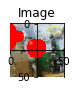

I am at position [-0.31, -0.06, 4.68]
I have found 2 out of 11 spheres!

I am now at position [-0.96, 0.2, 7.01]
I have found 3 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


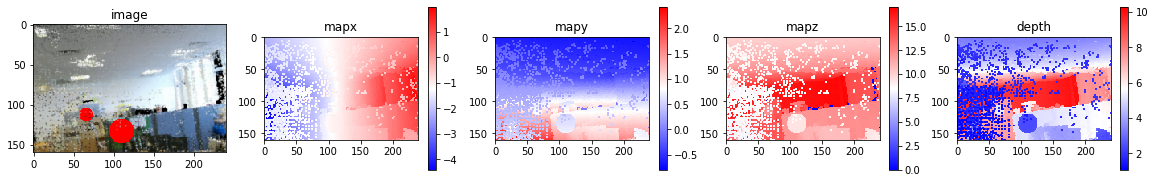


I have rotation  [0, 0, 0]
Prediction percentage: 1.0 

Middle pixel Depth: 1.2637127420886332
Coordinates of sphere: [-1.1880840063095093, 0.6789619891564467, 12.23631787001601]


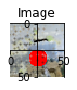

Prediction percentage: 1.0 

Middle pixel Depth: 1.1842772120067666
Coordinates of sphere: [-1.172936201095581, 0.33575502038002014, 8.16703987121582]


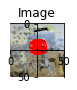

Prediction percentage: 1.0 

Middle pixel Depth: 2.425418262954448
Coordinates of sphere: [-1.0696901562103631, 0.5769423446966406, 9.39780922284723]


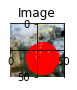

Prediction percentage: 1.0 

Middle pixel Depth: 2.4268764356137837
Coordinates of sphere: [-1.0118771936084283, 0.4513351023197174, 8.625673294067383]


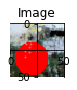

I am at position [-0.96, 0.2, 7.01]
I have found 3 out of 11 spheres!

I am now at position [-1.17, 0.34, 8.17]
PACMANFUNCTIONALITY - NO SPHERES AT LOCATION
I have found 3 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


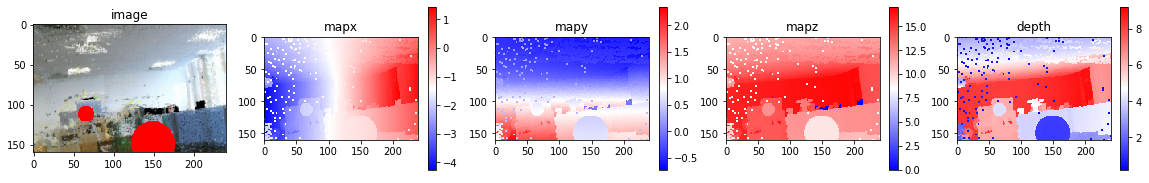


I have rotation  [0, 0, 0]
Prediction percentage: 1.0 

Middle pixel Depth: 4.122443875253934
Coordinates of sphere: [-1.8991187044292648, 0.7091808048824868, 12.199587417469356]


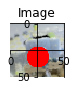

Prediction percentage: 1.0 

Middle pixel Depth: 4.096334547263014
Coordinates of sphere: [-1.900559708992358, 0.8011540638547315, 12.177579648763485]


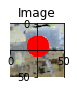

Prediction percentage: 1.0 

Middle pixel Depth: 1.3282946000008282
Coordinates of sphere: [-1.0982225603635594, 0.544855612200091, 9.46516807829372]


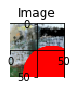

Prediction percentage: 1.0 

Middle pixel Depth: 1.2968806797903554
Coordinates of sphere: [-1.0577479881631588, 0.5408619891564467, 9.43881787001601]


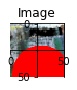

I am at position [-1.17, 0.34, 8.17]
I have found 3 out of 11 spheres!

I am now at position [-1.06, 0.54, 9.45]
I have found 4 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


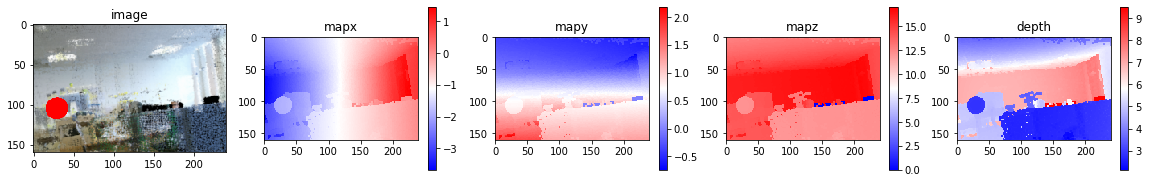


I have rotation  [0, 0, 0]
Prediction percentage: 1.0 

Middle pixel Depth: 2.9011400171174975
Coordinates of sphere: [-1.9227448478592497, 0.6998876147247716, 12.206632579868161]


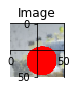

Prediction percentage: 1.0 

Middle pixel Depth: 2.906784325215616
Coordinates of sphere: [-1.863038411483008, 0.7014175400554008, 12.23631787001601]


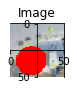

Prediction percentage: 1.0 

Middle pixel Depth: 2.863220436773368
Coordinates of sphere: [-1.9092368220047082, 0.7690969471394881, 12.175743408205024]


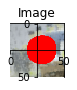

Prediction percentage: 1.0 

Middle pixel Depth: 2.8954894454680042
Coordinates of sphere: [-1.9173, 0.8579343599505447, 12.207876355934188]


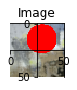

I am at position [-1.06, 0.54, 9.45]
I have found 4 out of 11 spheres!

I am now at position [-1.91, 0.77, 12.17]
I have found 5 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


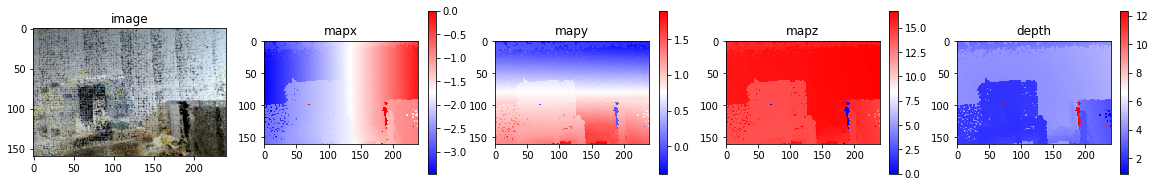


I have rotation  [0, 0, 0]
### No spheres found, rotating
Getting maps.... may take a while


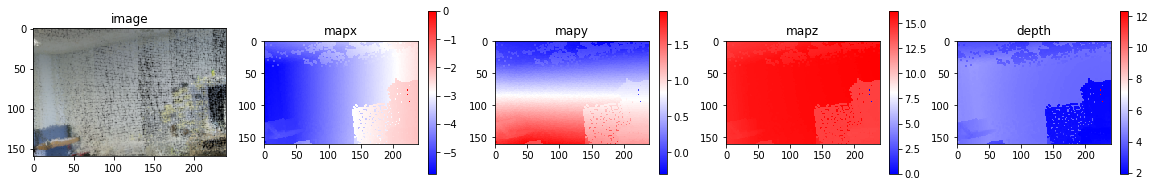


I have rotation  [0.0, -0.5235987755982988, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


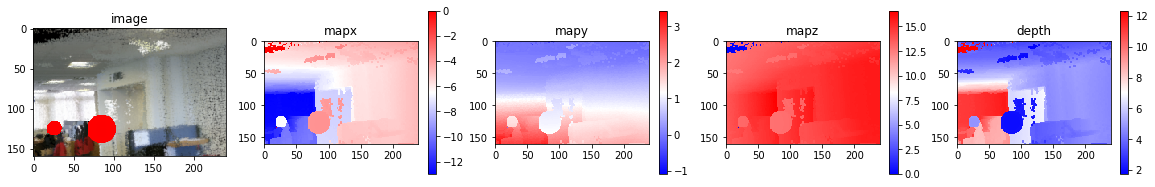


I have rotation  [0.0, -1.0471975511965976, 0.0]
Prediction percentage: 1.0 

Middle pixel Depth: 2.046479526961322
Coordinates of sphere: [-3.7972133615825943, 1.0197294988015297, 12.924120831832248]


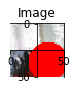

Prediction percentage: 1.0 

Middle pixel Depth: 2.0255347385009026
Coordinates of sphere: [-3.756605808647263, 1.0191002063366654, 12.971267790315016]


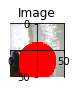

Prediction percentage: 1.0 

Middle pixel Depth: 2.0481713084272615
Coordinates of sphere: [-3.753574211399742, 1.0229323058600082, 13.033235221597216]


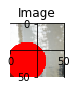

Prediction percentage: 1.0 

Middle pixel Depth: 4.812984800987354
Coordinates of sphere: [-6.55929982142686, 1.4525369981580354, 13.21066186206705]


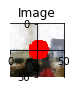

Prediction percentage: 1.0 

Middle pixel Depth: 2.0214291130303943
Coordinates of sphere: [-3.7661683186203043, 1.0649937105592437, 12.915554325596617]


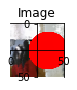

I am at position [-1.91, 0.77, 12.17]
I have found 5 out of 11 spheres!

I am now at position [-3.77, 1.08, 12.91]
I have found 6 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


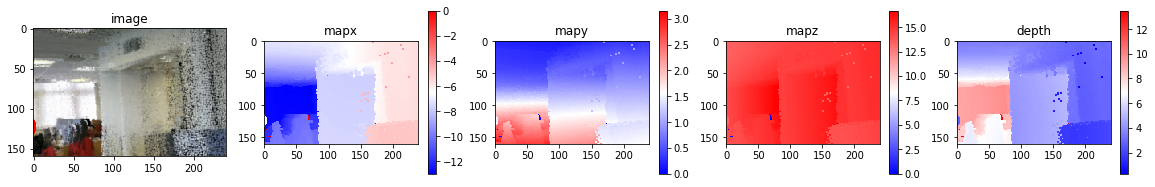


I have rotation  [0.0, -1.0471975511965976, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


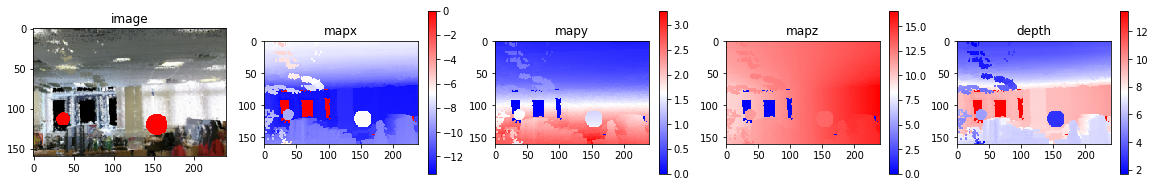


I have rotation  [0.0, -1.5707963267948966, 0.0]
Prediction percentage: 1.0 

Middle pixel Depth: 13.492494209744914
Coordinates of sphere: [0.0, 1.5576269610380844, 11.474476724392145]


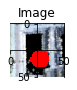

Prediction percentage: 1.0 

Middle pixel Depth: 5.335479987865397
Coordinates of sphere: [-8.879906506124428, 1.6683, 11.49681922777393]


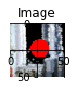

Prediction percentage: 1.0 

Middle pixel Depth: 2.861082981299913
Coordinates of sphere: [-6.599409356556018, 1.4321187065115653, 13.16679921626078]


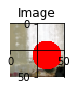

Prediction percentage: 1.0 

Middle pixel Depth: 2.8357961720386036
Coordinates of sphere: [-6.567997144877881, 1.428617454951107, 13.231409915657986]


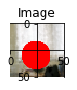

Prediction percentage: 1.0 

Middle pixel Depth: 2.8584191562536962
Coordinates of sphere: [-6.587948140276508, 1.499239496173726, 13.16679921626078]


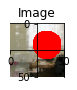

Prediction percentage: 1.0 

Middle pixel Depth: 2.8341495395075174
Coordinates of sphere: [-6.557319594810013, 1.4937261778750321, 13.231409915657986]


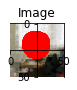

I am at position [-3.77, 1.08, 12.91]
I have found 6 out of 11 spheres!

I am now at position [-6.56, 1.49, 13.22]
I have found 7 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


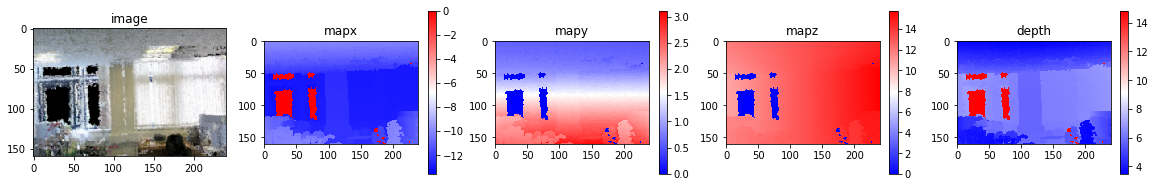


I have rotation  [0.0, -1.5707963267948966, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


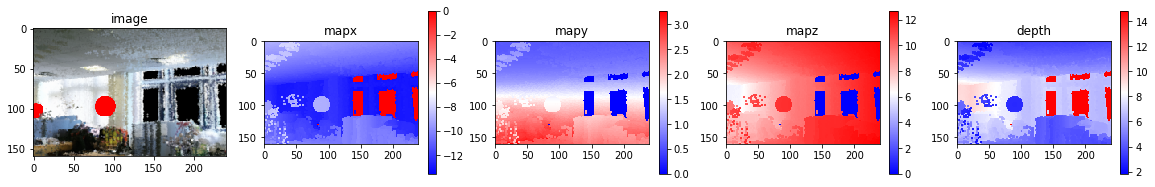


I have rotation  [0.0, -2.0943951023931953, 0.0]
Prediction percentage: 1.0 

Middle pixel Depth: 2.894377255788413
Coordinates of sphere: [-8.886475409621307, 1.6556994555219973, 11.514808810173896]


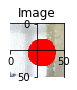

Prediction percentage: 1.0 

Middle pixel Depth: 2.897839575154254
Coordinates of sphere: [-8.929097070820879, 1.6566231879974174, 11.564867408893763]


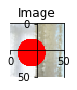

Prediction percentage: 1.0 

Middle pixel Depth: 2.907936702251261
Coordinates of sphere: [-8.893875798671225, 1.7270614934188777, 11.50513754669392]


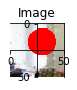

I am at position [-6.56, 1.49, 13.22]
I have found 7 out of 11 spheres!

I am now at position [-8.89, 1.65, 11.51]
I have found 8 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


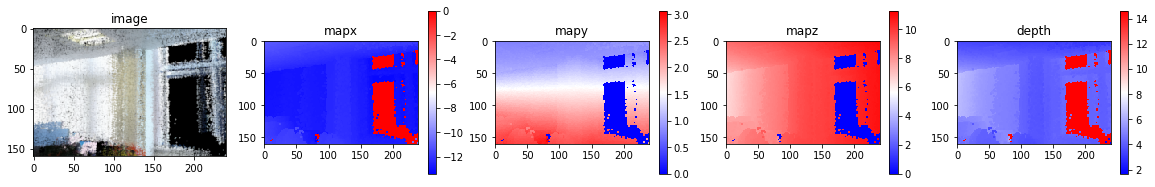


I have rotation  [0.0, -2.0943951023931953, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


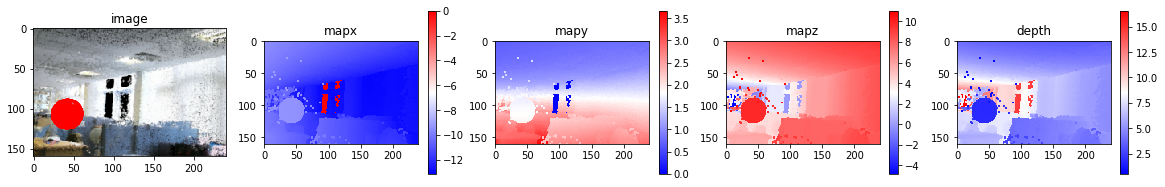


I have rotation  [0.0, -2.617993877991494, 0.0]
Prediction percentage: 1.0 

Middle pixel Depth: 7.188543421981656
Coordinates of sphere: [-10.465910911560059, 1.7539227538052717, 9.663609915657986]


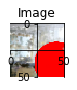

Prediction percentage: 1.0 

Middle pixel Depth: 1.8394756760327395
Coordinates of sphere: [-9.347867073547814, 1.7524401572045287, 9.739260894258909]


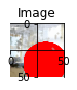

Prediction percentage: 1.0 

Middle pixel Depth: 1.8311150316786002
Coordinates of sphere: [-9.387531390369391, 1.7530126963875154, 9.75595385094301]


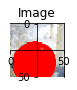

Prediction percentage: 1.0 

Middle pixel Depth: 1.860055069907849
Coordinates of sphere: [-9.296928063067584, 1.8032479495658809, 9.711227543403863]


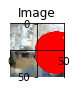

I am at position [-8.89, 1.65, 11.51]
I have found 8 out of 11 spheres!

I am now at position [-9.39, 1.75, 9.75]
I have found 9 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


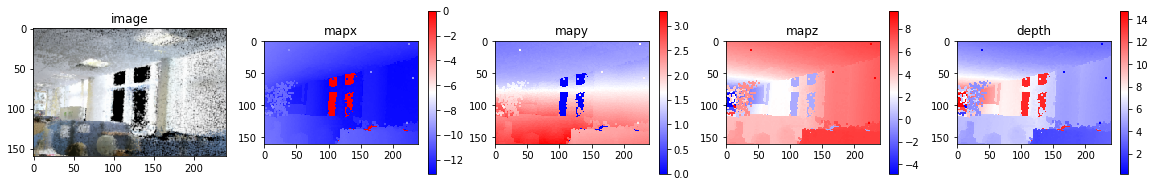


I have rotation  [0.0, -2.617993877991494, 0.0]
### No spheres found, rotating
Getting maps.... may take a while


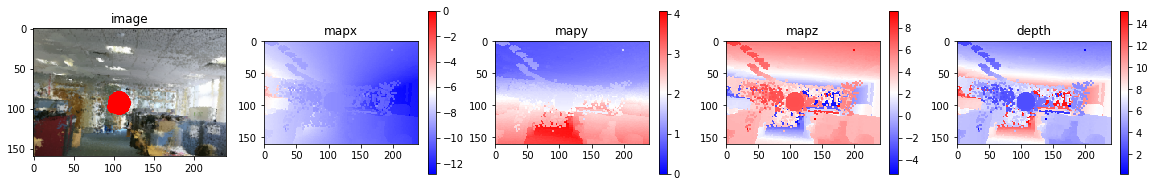


I have rotation  [0.0, -3.1415926535897927, 0.0]
Prediction percentage: 1.0 

Middle pixel Depth: 2.587715144760859
Coordinates of sphere: [-9.187106004008228, 1.8108228282930994, 7.208728186011301]


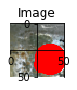

Prediction percentage: 1.0 

Middle pixel Depth: 2.5091098650301156
Coordinates of sphere: [-9.2761, 1.812473250753859, 7.249937796039343]


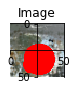

Prediction percentage: 1.0 

Middle pixel Depth: 2.5306331647856948
Coordinates of sphere: [-9.335545837514292, 1.8132014621856698, 7.220509472476941]


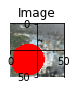

Prediction percentage: 1.0 

Middle pixel Depth: 2.533035768326134
Coordinates of sphere: [-9.191777169097206, 1.87284887043538, 7.237381232775401]


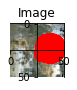

Prediction percentage: 1.0 

Middle pixel Depth: 2.4890184596093263
Coordinates of sphere: [-9.278178691948291, 1.8701713512763067, 7.2661877638846635]


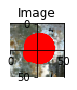

I am at position [-9.39, 1.75, 9.75]
I have found 9 out of 11 spheres!

I am now at position [-9.28, 1.87, 7.27]
I have found 10 out of 11 spheres!

###################################################################################################################################################
Getting maps.... may take a while


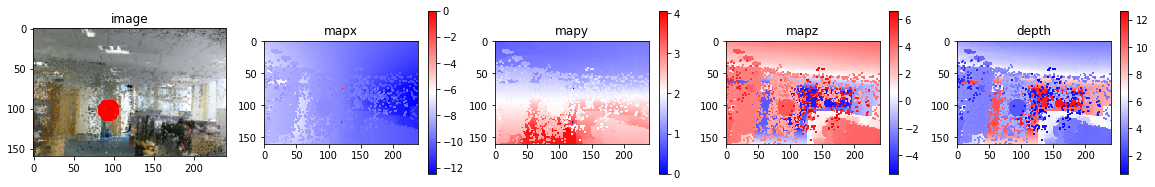


I have rotation  [0.0, -3.1415926535897927, 0.0]
Prediction percentage: 1.0 

Middle pixel Depth: 2.7742695024471478
Coordinates of sphere: [-8.972394154397568, 2.02738251659364, 4.529445674403385]


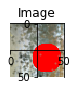

Prediction percentage: 1.0 

Middle pixel Depth: 2.747190960321432
Coordinates of sphere: [-9.044937056611197, 2.0287080938318334, 4.541738003000439]


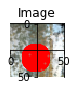

Prediction percentage: 1.0 

Middle pixel Depth: 2.75366627230638
Coordinates of sphere: [-8.97446775171774, 2.0928200971979476, 4.546636339162891]


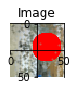

Prediction percentage: 1.0 

Middle pixel Depth: 2.7320506315193427
Coordinates of sphere: [-9.041451319616312, 2.0919521485167363, 4.555243027858744]


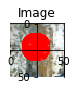

I am at position [-9.28, 1.87, 7.27]
I have found 10 out of 11 spheres!

I am now at position [-9.04, 2.08, 4.56]
I have found 11 out of 11 spheres!

###################################################################################################################################################


In [43]:
################ TEST ##################
# Took 24 minutes on PC
#   18 minutes on laptop
#   12 minutes on google

# Initilise game
from datetime import datetime
print('Start time:')
print(datetime.now().strftime('%H:%M:%S') )

import PacMan_functionality as PacMan
global_cloud, spheres_collected = PacMan.startup_scene()    # Have to use subsample, it effects acuracy but its way too slow otherwise
position = np.asarray([0, 0, 0])
angle = np.asarray([0, 0, 0])

while not np.all(spheres_collected): # While there are spheres to find
    # Get current image from viewpoint
    print('Getting maps.... may take a while')
    image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
    visualise_maps(image, mapx, mapy, mapz, depth)

    print('I have rotation  [{0}, {1}, {2}]'.format(*angle))

    # Extract patches from the scene    
    # Extract features from the patches

    #res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth # 20 leads to some individual picking up pixels error
    res = sliding_window_classifier(10, image, mapx, mapy, mapz, depth)

    # Predict the probability of a pixel being a sphere, based on the patch    
    # Use probabilities to find sphere coordinates in 3D

    if (len(res) > 0 ): # If spheres were found
        min_index = np.argmin(res[:,3])
        x = int(res[min_index, 0])    # From float to int
        y = int(res[min_index, 1])    

        # Get spacial coordinates of new sphere
        # and move there apparantly
        global_cloud, spheres_collected, position = sphere_position(x, y, position, spheres_collected)  

    else:   # No spheres found
        print('### No spheres found, rotating')
        #add pi/3 to roatation
        # Maybe reshow views?
        angle = angle - np.asarray([0, np.pi*1/6, 0])   # numpy + is an elementwise operation 
        #image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, new_angle, position)
        #visualise_maps(image, mapx, mapy, mapz, depth) # Visualise after rotation

        continue


    # Update camera appropriately
    
    # Update scene if needed

In [44]:
from datetime import datetime
print('End time:')
print(datetime.now().strftime('%H:%M:%S') )

End time:
19:55:10


Getting maps.... may take a while


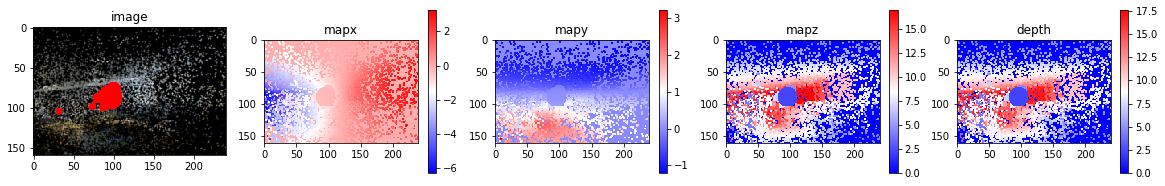


I have rotation  [0, 0, 0]
Prediction percentage: 1.0 

Middle pixel Depth: 14.298885957055878
Coordinates of sphere: [-1.6679456233978271, -0.021578330894868214, 2.3790972719239245]


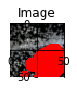

Prediction percentage: 1.0 

Middle pixel Depth: 2.362394660377316
Coordinates of sphere: [-0.18864053057926217, -0.019816509555381334, 2.3452208318322474]


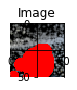

Prediction percentage: 1.0 

Middle pixel Depth: 4.701938957886521
Coordinates of sphere: [-0.258083725965501, -0.02068846886656743, 2.4060740851595215]


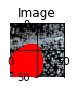

Prediction percentage: 1.0 

Middle pixel Depth: 7.139457323216012
Coordinates of sphere: [-1.024661505004536, 0.17517589436844233, 7.024262203960657]


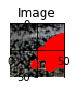

Prediction percentage: 1.0 

Middle pixel Depth: 2.3450562704232105
Coordinates of sphere: [-0.2603576553033593, 0.05510028477643353, 2.3234853872846455]


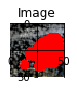

Prediction percentage: 1.0 

Middle pixel Depth: 12.418486366204366
Coordinates of sphere: [-1.8973065451988316, 0.7126327718900957, 12.224197464666874]


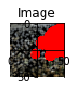

In [22]:
import PacMan_functionality as PacMan
global_cloud, spheres_collected = PacMan.startup_scene(subsample=100)    # Have to use subsample, it effects acuracy but its way too slow otherwise
position = np.asarray([0, 0, 0])
angle = np.asarray([0, 0, 0])

print('Getting maps.... may take a while')
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
visualise_maps(image, mapx, mapy, mapz, depth)

print('I have rotation  [{0}, {1}, {2}]'.format(*angle))

res = sliding_window_classifier(10, image, mapx, mapy, mapz, depth)

In [23]:
res

array([[60.        , 50.        ,  1.        , 14.29888596],
       [70.        , 50.        ,  1.        ,  2.36239466],
       [80.        , 50.        ,  1.        ,  4.70193896],
       [50.        , 60.        ,  1.        ,  7.13945732],
       [60.        , 60.        ,  1.        ,  2.34505627],
       [50.        , 70.        ,  1.        , 12.41848637]])

In [18]:
x = x[ x==1 ]


Prediction percentage: 1.0 

Middle pixel Depth: 8.927417912329389
Coordinates of sphere: [-1.076944351196289, -0.021578330894868214, 2.3790972719239245]


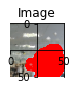

Prediction percentage: 1.0 

Middle pixel Depth: 2.362394660377316
Coordinates of sphere: [-0.18864053057926217, -0.019816509555381334, 2.3452208318322474]


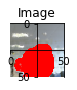

Prediction percentage: 1.0 

Middle pixel Depth: 4.701938957886521
Coordinates of sphere: [-0.258083725965501, -0.02068846886656743, 2.4060740851595215]


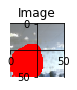

Prediction percentage: 1.0 

Middle pixel Depth: 2.3450562704232105
Coordinates of sphere: [-0.2603576553033593, 0.05510028477643353, 2.3234853872846455]


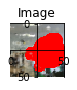

Prediction percentage: 1.0 

Middle pixel Depth: 2.358445152176713
Coordinates of sphere: [-0.26208158696191186, 0.11313504329078472, 2.3402081891374236]


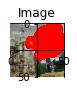

array([[60.        , 50.        ,  1.        ,  8.92741791],
       [70.        , 50.        ,  1.        ,  2.36239466],
       [80.        , 50.        ,  1.        ,  4.70193896],
       [60.        , 60.        ,  1.        ,  2.34505627],
       [60.        , 70.        ,  1.        ,  2.35844515]])

In [21]:
y = sliding_window_classifier(10, image, mapx, mapy, mapz, depth)
y

In [16]:
#

In [0]:
#[-11.947921752929688, 2.3431053161621094, 15.81285285949707]

In [0]:
#